# Spatial Filtering

### Image mean filtering

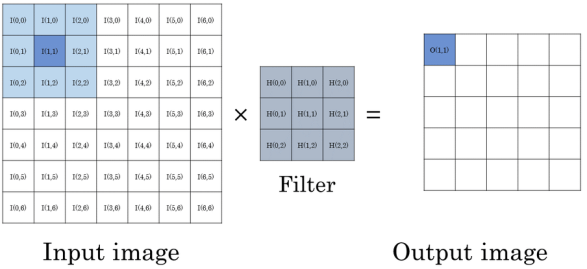

**Image mean filtering** หรือ **average filtering** เป็นเทคนิคประมวลผลภาพที่เรียบง่ายและใช้กันแพร่หลายเพื่อช่วยลดสัญญาณรบกวนในภาพ แนวคิดหลักคือแทนค่าพิกเซลแต่ละตำแหน่งในภาพด้วยค่าเฉลี่ยของพิกเซลรอบข้างรวมถึงตัวมันเอง การทำเช่นนี้ช่วยทำให้การเปลี่ยนแปลงความเข้มที่รวดเร็วเรียบขึ้นและลด noise ได้อย่างมีประสิทธิภาพ

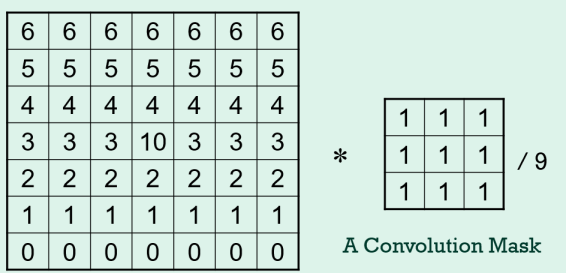

ภาพรวมการทำงานโดยสรุป:

- **1. การกำหนดบริเวณรอบข้าง (Neighborhood):** เริ่มจากกำหนดหน้าต่างรอบพิกเซลแต่ละจุด โดยทั่วไปเป็นหน้าต่างสี่เหลี่ยมจัตุรัสที่มีจุดศูนย์กลางอยู่ที่พิกเซลนั้น ขนาดหน้าต่างอาจต่างกัน เช่น 3x3, 5x5 หรือ 7x7 พิกเซล
- **2. การคำนวณค่าเฉลี่ย:** สำหรับพิกเซลแต่ละจุด ให้คำนวณค่าเฉลี่ยของค่าพิกเซลทั้งหมดภายในหน้าต่างที่กำหนด ซึ่งรวมถึงพิกเซลกลางด้วย
- **3. การแทนค่าพิกเซล:** แทนค่าพิกเซลเดิมด้วยค่าเฉลี่ยที่คำนวณได้ ทำเช่นนี้กับทุกพิกเซลในภาพ


สรุปการทำงาน:

1. สร้าง kernel - ตัวน้ำหนักสำหรับการกรอง
2. วนลูปทุกพิกเซล (ยกเว้นขอบ)
3. ดึงบริเวณรอบ ๆ - หน้าต่าง k×k
4. คูณด้วย kernel - ให้น้ำหนักกับแต่ละพิกเซล
5. รวมผลลัพธ์ - ได้ค่าพิกเซลใหม่ (blur)

### นำเข้าโมดูล

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

### โมดูลแสดงภาพ

In [2]:
def plt_show(img):
    plt.axis("off")
    plt.imshow(img, cmap='gray') #RGB
    plt.show()

In [3]:
def cv_show(img):
    cv2.imshow('Mean Filtered Image', img) #BGR
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### วิธีที่ 1 ใช้ไลบรารี cv

In [4]:
def Blur(img, k):
    return cv2.blur(img, (k, k)).astype(np.uint8)

In [5]:
def filterImage(img, k):
    mask = np.ones([k,k], dtype = 'float16')/ 9
    # ตัวอย่าง kernel Gaussian 3x3
    #mask = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype='float16')     
    #mask = mask/16  # ปรับให้ผลรวมเป็น 1
    return cv2.filter2D(img, -1, mask)    

### 1. อ่านภาพ

In [6]:
gray = cv2.imread('./img/lena_salt_512.png', 0) # 0 คืออ่านภาพเป็น grayscale หรือ cv2.IMREAD_GRAYSCALE 

In [7]:
blur_img = Blur(gray,7) #ยิ่งใหญ่ค่าของ k ยิ่งเบลอมากขึ้น
# ตัวอย่างการใช้ cv2.blur ด้วยหน้าต่าง 3x3
#blur_img = cv2.blur(gray, (3, 3)).astype(np.uint8)
imgs = cv2.hconcat([gray, blur_img])
cv_show(imgs)


In [8]:
def filterImage(img, k):
    # ตัวเลือก: kernel ค่าเฉลี่ยขนาด k x k
    #mask = np.ones([k,k], dtype = 'float16')/ (k**2)
    mask = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype='float16')     
    mask = mask/16  # ปรับให้น้ำหนักรวมเป็น 1
    return cv2.filter2D(img, -1, mask).astype(np.uint8)



##### **ตัวอย่างความแตกต่าง Kernel**

**Blur (ค่าเฉลี่ยธรรมดา 3×3):** Box filtering => ค่าเฉลี่ย ธรรมชาติ - ทุกพิกเซลมีน้ำหนักเท่ากันเท่านั้น
```
Kernel:
1/9  1/9  1/9
1/9  1/9  1/9
1/9  1/9  1/9

✓ ทุกตำแหน่ง = มีอิทธิพลเท่ากัน
```

**filterImage (Gaussian 3×3):**  พิกเซลกลางมีน้ำหนักมากกว่า
```
Kernel:
1/16  2/16  1/16
2/16  4/16  2/16
1/16  2/16  1/16

✓ พิกเซลกลาง (4/16) = มีอิทธิพล 4 เท่า
✓ ทำให้เบลอ แต่ยังรักษารายละเอียดได้ดี
```


### วิธีที่ 2 สร้างฟังก์ชันด้วยตัวเอง (Custom Implementation)

**ขั้นตอนการทำงานของ filterCustom:**

**1. สร้าง Kernel (ตัวน้ำหนัก)**
```
mask = np.ones([k,k], dtype = 'float')/ (k**2)
```
- สร้าง kernel ขนาด k×k โดยทั้งหมดเป็นค่า 1
- หารด้วย k² เพื่อ normalization (ให้ผลรวม = 1)
- ตัวอย่าง: k=3 → mask 3×3 แต่ละเซลล์มีค่า 1/9 ≈ 0.111

**2. ดึงขนาดภาพและสร้างภาพผลลัพธ์**
```
(m,n) = img.shape     # m=ความสูง, n=ความกว้าง
out = img.copy()      # คัดลอกภาพเดิม
bd = int(k/2)         # ระยะขอบ = ครึ่งของ k
```

**3. วนลูปผ่านทุกพิกเซล (ยกเว้นขอบ)**
```
for i in range(bd, m-bd):
    for j in range(bd, n-bd):
```
- ข้ามพิกเซลที่ขอบ เพราะไม่มี neighbors พอ
- ตัวอย่าง: k=3 (bd=1) → ข้ามแถว/คอลัมน์แรกและสุดท้าย

**4. ดึงบริเวณรอบพิกเซลและคำนวณค่าเฉลี่ย**
```
sub_f = img[i-bd : i+bd+1, j-bd : j+bd+1].astype(np.float16)
out[i, j] = np.multiply(sub_f, mask).sum()
```
- ดึงหน้าต่าง k×k รอบพิกเซล (i,j)
- คูณด้วย kernel แต่ละตำแหน่ง
- รวมผลลัพธ์ = ค่าเฉลี่ยของพิกเซลรอบข้าง

**5. แปลงกลับเป็น uint8 และคืนภาพ**
```
return out.astype(np.uint8)
```


In [9]:
def filterCustom(img, k):
    # ขั้นตอนที่ 1: สร้าง kernel (mask) ขนาด k×k
    # np.ones([k,k]) สร้างเมตริกซ์ที่มีค่า 1 ทั้งหมด
    # หารด้วย k**2 เพื่อ normalization (ผลรวม = 1)
    mask = np.ones([k,k], dtype = 'float')/ (k**2)
    
    # ตัวอย่าง: ใช้ kernel Gaussian 3x3 แทน
    #mask = np.array([[1,2,1],[2,4,2],[1,2,1]], dtype='float16')     
    #mask = mask/16  # ปรับให้น้ำหนักรวมเป็น 1
    
    # ขั้นตอนที่ 2: ดึงมิติของภาพ (m=สูง, n=กว้าง)
    (m,n) = img.shape
    
    # วิธีการสร้างภาพผลลัพธ์ (เลือกหนึ่งวิธี)
    #out = np.zeros((m,n), dtype = 'float16')  # สร้างภาพเปล่า
    #out = np.zeros_like(img, dtype = 'float16')  # สร้างภาพเปล่าเหมือนต้นฉบับ
    out = img.copy()  # คัดลอกภาพเดิม (เก็บค่าขอบไว้)
    
    # ขั้นตอนที่ 3: หาระยะขอบ (ครึ่งของ kernel size)
    bd = int(k/2)
    
    # ขั้นตอนที่ 4: วนลูปผ่านทุกพิกเซล (ยกเว้นขอบ)
    for i in range(bd, m-bd):
        for j in range(bd, n-bd):
            # ดึงบริเวณรอบพิกเซล (i,j) ขนาด k×k
            sub_f = img[i - bd : i + bd + 1, j - bd : j + bd + 1].astype(np.float16)
            
            # คำนวณค่าเฉลี่ยถ่วงน้ำหนัก
            # np.multiply = คูณแต่ละตำแหน่งด้วย kernel
            # .sum() = รวมผลลัพธ์ทั้งหมด
            out[i, j] = np.multiply(sub_f, mask).sum()    
    
    # ขั้นตอนที่ 5: แปลงกลับเป็น uint8 (ค่า 0-255)
    return out.astype(np.uint8)

In [10]:
blur_img =filterCustom(gray, 7)
imgs = cv2.hconcat([gray, blur_img])
cv_show(imgs)

#### ตัวอย่างการคำนวณให้เห็นภาพ

**สมมติว่าเรามีพิกเซลรอบ ๆ ตำแหน่ง (i,j) ขนาด 3×3:**

```
พิกเซลรอบ ๆ (3×3):
┌───────────────────┐
│ 100  110  120     │
│ 105  150  125     │
│  95  105  115     │
└───────────────────┘

พิกเซลกลาง (ก่อนกรอง) = 150
```

---

### 📊 **วิธีที่ 1: Mean Filtering (ค่าเฉลี่ยธรรมดา)**

**Kernel (mask) สำหรับค่าเฉลี่ย:**
```
┌─────────────────────────────┐
│ 0.1111  0.1111  0.1111      │
│ 0.1111  0.1111  0.1111      │
│ 0.1111  0.1111  0.1111      │
└─────────────────────────────┘
แต่ละตำแหน่ง = 1/9 = 0.1111
```

**ผลการคูณ (np.multiply):**
```
┌─────────────────────────────┐
│ 11.11  12.22  13.33         │
│ 11.67  16.67  13.89         │
│ 10.56  11.67  12.78         │
└─────────────────────────────┘
```

**ผลรวม (.sum()) = 113.89**

```
✅ พิกเซลกลาง (หลังกรอง) = 114
```

**สรุป:**
- 📍 ก่อนกรอง: **150**
- 📍 หลังกรอง: **114**
- 📍 ผลต่าง: **36** (เบลอลงเพราะหาค่าเฉลี่ย)

---

### 🎯 **วิธีที่ 2: Gaussian Filtering**

**Gaussian Kernel:**
```
┌─────────────────────────────┐
│ 0.0625  0.1250  0.0625      │  (1/16, 2/16, 1/16)
│ 0.1250  0.2500  0.1250      │  (2/16, 4/16, 2/16)
│ 0.0625  0.1250  0.0625      │  (1/16, 2/16, 1/16)
└─────────────────────────────┘
พิกเซลกลางมีน้ำหนัก 4/16 = มากที่สุด
```

**ผลการคูณด้วย Gaussian:**
```
┌─────────────────────────────┐
│  6.25   13.75    7.50       │
│ 13.13   37.50   15.63       │
│  5.94   13.13    7.19       │
└─────────────────────────────┘
```

**ผลรวม = 120.02**

```
✅ พิกเซลกลาง (Gaussian) = 120
```

---

### 📈 **สรุปเปรียบเทียบ**

| วิธี | ผลลัพธ์ | ห่างจากต้นฉบับ |
|------|---------|---------------|
| 🔵 **ต้นฉบับ** | **150** | - |
| 🟢 **Mean Filtering** | **114** | 36 (ห่างมาก) |
| 🟡 **Gaussian Filter** | **120** | 30 (ห่างน้อยกว่า) |

**💡 ข้อสังเกต:**
- Gaussian **ใกล้เคียงต้นฉบับมากกว่า** → รักษารายละเอียดได้ดีกว่า
- พิกเซลกลางใน Gaussian มีน้ำหนัก 0.25 (25%) ในขณะที่ Mean มีเพียง 0.11 (11%)
- Gaussian เหมาะกับการลด noise โดยยังคงความคมชัดไว้


### สรุปความแตกต่างหลัก

| ฟังก์ชัน | Library | Kernel | ความเร็ว | ใช้เพื่อ |
|---------|---------|--------|--------|--------|
| **Blur** | cv2.blur() | ค่าเฉลี่ยธรรมดา | ⚡⚡⚡ เร็วที่สุด | ใช้งานจริง |
| **filterImage** | cv2.filter2D() | Gaussian 3×3 | ⚡⚡ เร็ว | คุณภาพดี |
| **filterCustom** | for loop | ค่าเฉลี่ยธรรมดา | 🐢 ช้าที่สุด | เข้าใจวิธีการ |

**ข้อแนะนำการใช้:**
- ✅ **ใช้ Blur** - ถ้าต้องการความเร็ว
- ✅ **ใช้ filterImage** - ถ้าต้องการคุณภาพที่ดี
- ✅ **ใช้ filterCustom** - ถ้าต้องการเรียนรู้วิธีการทำงาน
